# Intel Image Classifcation Using Transfer Learning
**kaggle link**: https://www.kaggle.com/puneet6060/intel-image-classification

Description
Context

This is image data of Natural Scenes around the world.
Content

This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.



In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

## Download and Prepare data from Kaggle

In [2]:
os.environ['KAGGLE_USERNAME'] = "saravanavelv" # username from the json file
os.environ['KAGGLE_KEY'] = "9aa988177e35775b47a38f11fdf2931f" # key from the json file

In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification #download data from kaggle

 96% 331M/346M [00:02<00:00, 95.6MB/s]
100% 346M/346M [00:02<00:00, 123MB/s] 


In [4]:
!ls

intel-image-classification.zip	sample_data


In [5]:
!mkdir dataset

In [6]:
!unzip -q intel-image-classification.zip -d dataset/

In [7]:
!ls

dataset  intel-image-classification.zip  sample_data


In [8]:
!ls dataset/

seg_pred  seg_test  seg_train


In [9]:
!ls dataset/seg_train/seg_train/

buildings  forest  glacier  mountain  sea  street


In [10]:
# Walk through pizza_steak directory and list number of files
print("Train data: ")
for dirpath, dirnames, filenames in os.walk("dataset/seg_train/seg_train/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Test data: ")
for dirpath, dirnames, filenames in os.walk("dataset/seg_test/seg_test/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Prediction data: ")
for dirpath, dirnames, filenames in os.walk("dataset/seg_pred/seg_pred/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Train data: 
There are 6 directories and 0 images in 'dataset/seg_train/seg_train/'.
There are 0 directories and 2191 images in 'dataset/seg_train/seg_train/buildings'.
There are 0 directories and 2274 images in 'dataset/seg_train/seg_train/sea'.
There are 0 directories and 2512 images in 'dataset/seg_train/seg_train/mountain'.
There are 0 directories and 2382 images in 'dataset/seg_train/seg_train/street'.
There are 0 directories and 2271 images in 'dataset/seg_train/seg_train/forest'.
There are 0 directories and 2404 images in 'dataset/seg_train/seg_train/glacier'.
Test data: 
There are 6 directories and 0 images in 'dataset/seg_test/seg_test/'.
There are 0 directories and 437 images in 'dataset/seg_test/seg_test/buildings'.
There are 0 directories and 510 images in 'dataset/seg_test/seg_test/sea'.
There are 0 directories and 525 images in 'dataset/seg_test/seg_test/mountain'.
There are 0 directories and 501 images in 'dataset/seg_test/seg_test/street'.
There are 0 directories and 47

# Explore images

In [11]:
import random
import matplotlib.pyplot as plt
def view_random_image(target_dir, target_class):
  # We will view image from here
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder+'/'+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');
  print(f"Image shape {img.shape}")

  return img

Image shape (150, 150, 3)


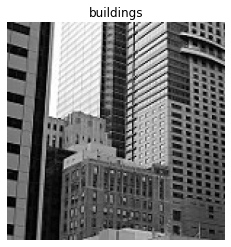

In [17]:
img = view_random_image(target_dir='dataset/seg_train/seg_train/',
                  target_class='buildings')

## Print bunch of random images

In [18]:
# Get the class name programmatically
import pathlib
data_dir = pathlib.Path("dataset/seg_train/seg_train/")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [19]:
random.choice(class_names)

'glacier'

Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)


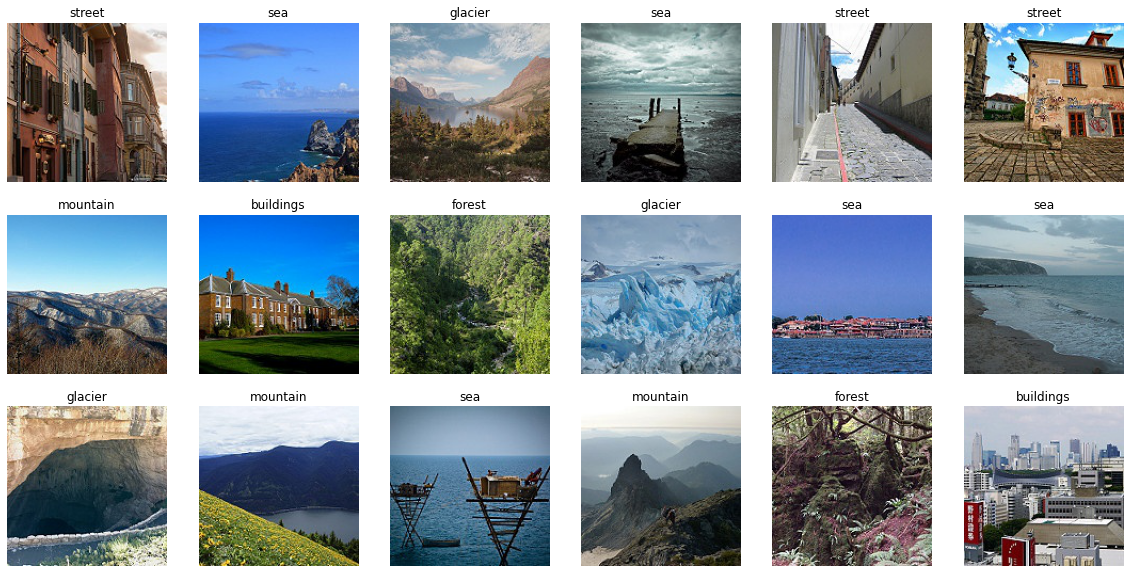

In [20]:
plt.figure(figsize=(20, 10))
for i in range(18):
  plt.subplot(3, 6, i+1)
  class_name = random.choice(class_names)
  img = view_random_image(target_dir='dataset/seg_train/seg_train/',
                  target_class=class_name)

# Prepare data for model

In [21]:
train_dir = "dataset/seg_train/seg_train"
test_dir = "dataset/seg_test/seg_test"

In [22]:
# Create augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.)

# Load data(data, label) from directory and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical')
test_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=(150,150),
                                           batch_size=32,
                                           class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Basic model Buildinig a CNN Classifier

In [23]:
len(class_names)

6

In [24]:
model_1 = Sequential([
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(150,150,3)),
  MaxPool2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names), activation='softmax')
])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [25]:
model_1.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=['accuracy'])

In [26]:
history_1 = model_1.fit(train_data,
                    epochs=20,
                    batch_size=32,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/20
439/439 [==============================] - 111s 182ms/step - loss: 1.0113 - accuracy: 0.6048 - val_loss: 0.7869 - val_accuracy: 0.7067
Epoch 2/20
439/439 [==============================] - 80s 182ms/step - loss: 0.7588 - accuracy: 0.7176 - val_loss: 0.6327 - val_accuracy: 0.7750
Epoch 3/20
439/439 [==============================] - 79s 180ms/step - loss: 0.6507 - accuracy: 0.7604 - val_loss: 0.6764 - val_accuracy: 0.7527
Epoch 4/20
439/439 [==============================] - 78s 178ms/step - loss: 0.5998 - accuracy: 0.7801 - val_loss: 0.4953 - val_accuracy: 0.8270
Epoch 5/20
439/439 [==============================] - 78s 179ms/step - loss: 0.5510 - accuracy: 0.7983 - val_loss: 0.4879 - val_accuracy: 0.8283
Epoch 6/20
439/439 [==============================] - 79s 179ms/step - loss: 0.5262 - accuracy: 0.8073 - val_loss: 0.4474 - val_accuracy: 0.8423
Epoch 7/20
439/439 [==============================] - 78s 178ms/step - loss: 0.5010 - accuracy: 0.8172 - val_loss: 0.4535 - val_a

In [27]:
loss_and_acc=model_1.evaluate(test_data)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

94/94 [==============================] - 3s 33ms/step - loss: 0.3806 - accuracy: 0.8687
Test Loss 0.3806414008140564
Test Accuracy 0.8686666488647461


Text(0, 0.5, 'Loss')

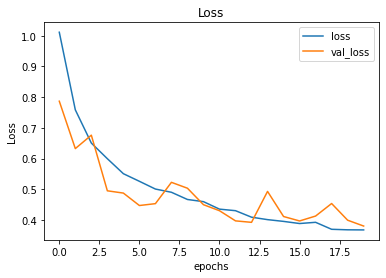

In [28]:
pd.DataFrame(history_1.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')

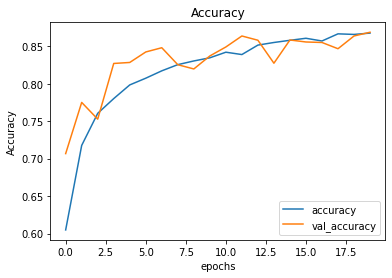

In [29]:
pd.DataFrame(history_1.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy');

# Transfer learning model

In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

## Creating feature extractor model callbacks

In [31]:
# Get helper functions file
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [32]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [33]:
from helper_functions import create_tensorboard_callback


# Create ModelCheckpoint callback to save best model 
checkpoint_path = "feature_extraction_model_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

## Setting up mixed precision training

In [34]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

## Feature extraction model

In [35]:
len(class_names)

6

In [36]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
# Create base model
input_shape = (150,150,3)
base_model = VGG16(include_top=False, weights = 'imagenet')
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(len(class_names))(x)

# Create output layer and combine them
outputs = layers.Activation("softmax", dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
_________________________________________________________________
softmax_float32 (Activation) (None, 6)                 0         
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [38]:
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[create_tensorboard_callback("training_logs",
                                                          "vgg16_mobile_feature_extract"),
                              model_checkpoint])

Saving TensorBoard log files to: training_logs/vgg16_mobile_feature_extract/20210819-095611
Epoch 1/10
439/439 [==============================] - 88s 197ms/step - loss: 1.0247 - accuracy: 0.6789 - val_loss: 0.6561 - val_accuracy: 0.7940
INFO:tensorflow:Assets written to: feature_extraction_model_checkpoints/assets
Epoch 2/10
439/439 [==============================] - 86s 196ms/step - loss: 0.6585 - accuracy: 0.7832 - val_loss: 0.5348 - val_accuracy: 0.8143
INFO:tensorflow:Assets written to: feature_extraction_model_checkpoints/assets
Epoch 3/10
439/439 [==============================] - 86s 195ms/step - loss: 0.5748 - accuracy: 0.8013 - val_loss: 0.4753 - val_accuracy: 0.8343
INFO:tensorflow:Assets written to: feature_extraction_model_checkpoints/assets
Epoch 4/10
439/439 [==============================] - 85s 194ms/step - loss: 0.5373 - accuracy: 0.8105 - val_loss: 0.4474 - val_accuracy: 0.8420
INFO:tensorflow:Assets written to: feature_extraction_model_checkpoints/assets
Epoch 5/10
4

In [39]:
loss_and_acc=model.evaluate(test_data)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

94/94 [==============================] - 4s 42ms/step - loss: 0.3924 - accuracy: 0.8560
Test Loss 0.3923704922199249
Test Accuracy 0.8560000061988831


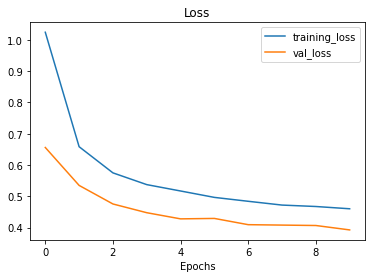

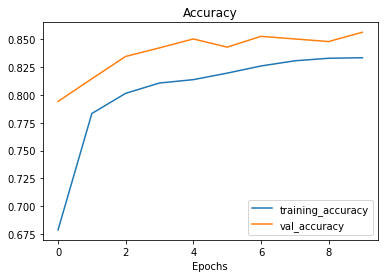

In [40]:
plot_loss_curves(history)

## Load and evaluate checkpoint weights

In [41]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
_________________________________________________________________
softmax_float32 (Activation) (None, 6)                 0         
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [42]:
cloned_model.load_weights(checkpoint_path)

In [43]:
cloned_model.load_weights(checkpoint_path)

In [44]:
cloned_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [45]:
loss_and_acc=cloned_model.evaluate(test_data)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

94/94 [==============================] - 4s 43ms/step - loss: 0.3924 - accuracy: 0.8560
Test Loss 0.3923701047897339
Test Accuracy 0.8560000061988831


## Setup all callbacks before final model

In [46]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [47]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

## Fine tune feature extraction model

In [48]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
# Create base model
input_shape = (150,150,3)
base_model = VGG16(include_top=False, weights = 'imagenet')
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# x = preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(len(class_names))(x)

# Create output layer and combine them
outputs = layers.Activation("softmax", dtype=tf.float32, name='softmax_float32')(x)
model_fine_tune = tf.keras.Model(inputs, outputs)
model_fine_tune.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
_________________________________________________________________
softmax_float32 (Activation) (None, 6)                 0         
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [49]:
# Set entire model trainable (no frozeen layer)
for layer in model_fine_tune.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 
  # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
vgg16 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_3 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [50]:
len(model_fine_tune.layers)

5

In [51]:
# Compile the model
model_fine_tune.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [52]:
# Start to fine-tune (all layers)
history_fine_tune = model_fine_tune.fit(train_data,
                                        epochs=20, # fine-tune for a maximum of 100 epochs
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                        callbacks=[create_tensorboard_callback("training_logs", "model_vgg_mobile_image_fine_tuning"), # track the model training logs
                                                    model_checkpoint, # save only the best model during training
                                                    early_stopping, # stop model after X epochs of no improvements
                                                    reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/model_vgg_mobile_image_fine_tuning/20210819-101236
Epoch 1/20
439/439 [==============================] - 111s 222ms/step - loss: 0.4757 - accuracy: 0.8281 - val_loss: 0.2810 - val_accuracy: 0.9018
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 2/20
439/439 [==============================] - 91s 208ms/step - loss: 0.3238 - accuracy: 0.8898 - val_loss: 0.2195 - val_accuracy: 0.9174
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 3/20
439/439 [==============================] - 91s 207ms/step - loss: 0.2737 - accuracy: 0.9027 - val_loss: 0.2088 - val_accuracy: 0.9241
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 4/20
439/439 [==============================] - 92s 208ms/step - loss: 0.2479 - accuracy: 0.9134 - val_loss: 0.2502 - val_accuracy: 0.9107
Epoch 5/20
439/439 [==============================] - 91s 206ms/step - loss: 0.2353 - accuracy: 0.9181 - val_loss: 0.2489 - val_a

In [53]:
loss_and_acc=model_fine_tune.evaluate(test_data)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

94/94 [==============================] - 4s 42ms/step - loss: 0.2284 - accuracy: 0.9223
Test Loss 0.22844840586185455
Test Accuracy 0.9223333597183228


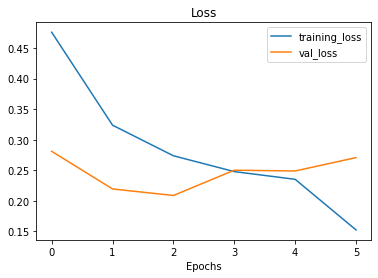

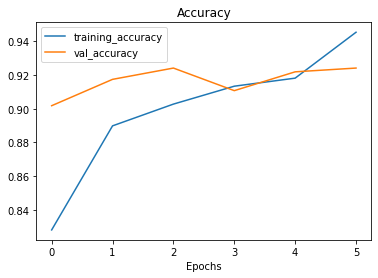

In [54]:
plot_loss_curves(history_fine_tune)

In [55]:
cloned_model_fine_tune = tf.keras.models.clone_model(model_fine_tune)
cloned_model_fine_tune.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
_________________________________________________________________
softmax_float32 (Activation) (None, 6)                 0         
Total params: 14,717,766
Trainable params: 14,717,766
Non-trainable params: 0
_________________________________________________________________


In [56]:
cloned_model_fine_tune.load_weights(checkpoint_path)

In [57]:
cloned_model_fine_tune.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [58]:
loss_and_acc=cloned_model_fine_tune.evaluate(test_data)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

94/94 [==============================] - 4s 41ms/step - loss: 0.2444 - accuracy: 0.9153
Test Loss 0.2444441318511963
Test Accuracy 0.9153333306312561


## Make prediction using our final trained model

In [59]:
def load_and_prep_image(filename, img_shape=150, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [60]:
pred_img = os.listdir("dataset/seg_pred/seg_pred/")
import random
custom_images = []
for i in range(10):
  custom_images.append("dataset/seg_pred/seg_pred/"+random.choice(pred_img))

custom_images

['dataset/seg_pred/seg_pred/20442.jpg',
 'dataset/seg_pred/seg_pred/15077.jpg',
 'dataset/seg_pred/seg_pred/15427.jpg',
 'dataset/seg_pred/seg_pred/20130.jpg',
 'dataset/seg_pred/seg_pred/1076.jpg',
 'dataset/seg_pred/seg_pred/20977.jpg',
 'dataset/seg_pred/seg_pred/3289.jpg',
 'dataset/seg_pred/seg_pred/22791.jpg',
 'dataset/seg_pred/seg_pred/10305.jpg',
 'dataset/seg_pred/seg_pred/13501.jpg']

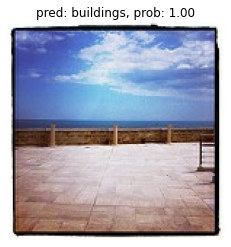

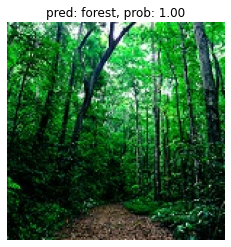

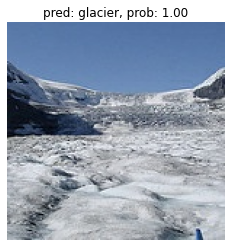

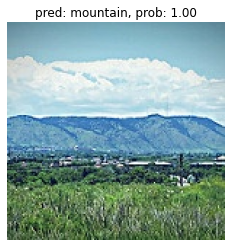

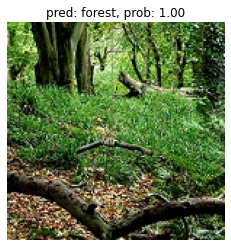

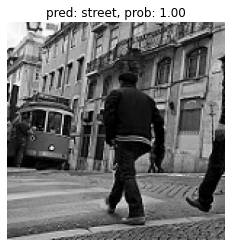

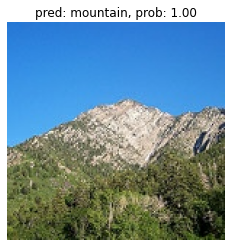

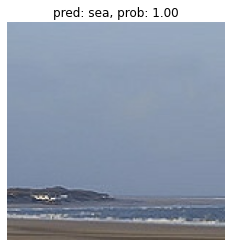

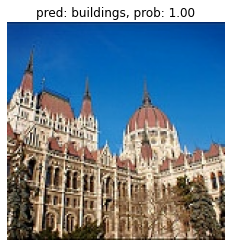

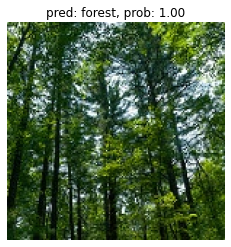

In [61]:
# Make predictions on custom images
for img in custom_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = cloned_model_fine_tune.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 150, 150, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

# THANK YOU!!